# Topic Modeling for Research Articles


Researchers have access to large online archives of scientific articles. As a consequence, finding relevant articles has become more difficult. Tagging or topic modelling provides a way to give token of identification to research articles which facilitates recommendation and search process.

Given the abstract and title for a set of research articles, predict the topics for each article included in the test set. 

Note that a research article can possibly have more than 1 topic. The research article abstracts and titles are sourced from the following 6 topics: 

1. Computer Science

2. Physics

3. Mathematics

4. Statistics

5. Quantitative Biology

6. Quantitative Finance

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

import nltk
nltk.download("punkt")
nltk.download("stopwords")
nltk.download("wordnet")
from nltk.stem import PorterStemmer,WordNetLemmatizer


import re

from gensim.parsing.preprocessing import preprocess_string,strip_tags,strip_punctuation,remove_stopwords,strip_numeric,stem_text

from sklearn.model_selection import GridSearchCV,train_test_split

from sklearn.feature_extraction.text import TfidfTransformer,HashingVectorizer

from sklearn.preprocessing import LabelEncoder,StandardScaler,RobustScaler,Normalizer

from sklearn.decomposition import TruncatedSVD

from sklearn.pipeline import Pipeline

from sklearn.svm import LinearSVC,SVC

from sklearn.multiclass import OneVsRestClassifier

from sklearn.metrics import precision_score,recall_score,f1_score,accuracy_score


[nltk_data] Downloading package punkt to /home/ritesh/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/ritesh/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/ritesh/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
train = pd.read_csv("/home/ritesh/Documents/Project/Topic_modeling/train.csv")
test = pd.read_csv("/home/ritesh/Documents/Project/Topic_modeling/test.csv")

submission = pd.read_csv("/home/ritesh/Documents/Project/Topic_modeling/sample_submission.csv")

In [3]:
print(train.isnull().any())
print(train.columns)

ID                      False
TITLE                   False
ABSTRACT                False
Computer Science        False
Physics                 False
Mathematics             False
Statistics              False
Quantitative Biology    False
Quantitative Finance    False
dtype: bool
Index(['ID', 'TITLE', 'ABSTRACT', 'Computer Science', 'Physics', 'Mathematics',
       'Statistics', 'Quantitative Biology', 'Quantitative Finance'],
      dtype='object')


In [4]:
test.isnull().any()

ID          False
TITLE       False
ABSTRACT    False
dtype: bool

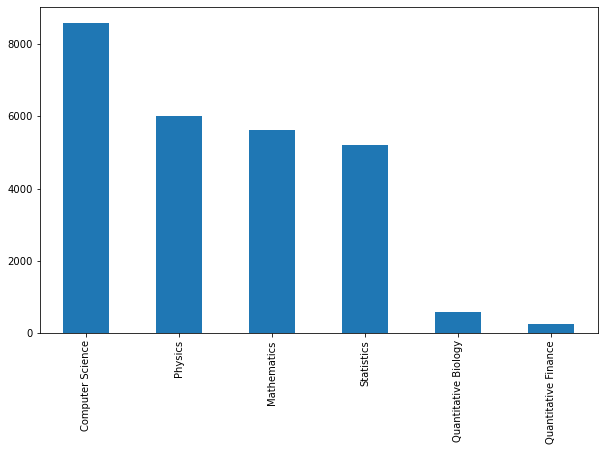

In [5]:
# Converting Binary Column to category

target_columns = ['Computer Science', 'Physics', 'Mathematics',
       'Statistics', 'Quantitative Biology', 'Quantitative Finance']
y = train[target_columns]

# plot category data

plt.figure(figsize=(10,6))
y.sum(axis=0).plot.bar()
plt.show()

# Data Preprocessing

In [6]:
# Stemmer object
porter = PorterStemmer()
wnl = WordNetLemmatizer()

class DataPreprocess:
    
    def __init__(self):
        self.filters = [strip_tags,
                       strip_numeric,
                       strip_punctuation,
                       lambda x: x.lower(),
                       lambda x: re.sub(r'\s+\w{1}\s+', '', x),
                       remove_stopwords]
    def __call__(self, doc):
        clean_words = self.__apply_filter(doc)
        return clean_words
    
    def __apply_filter(self, doc):
        try:
            cleanse_words = set(preprocess_string(doc, self.filters))
#             filtered_words = set(wnl.lemmatize(w) if w.endswith('e') else porter.stem(w) for w in cleanse_words)
            filtered_words = set(wnl.lemmatize(word, 'v') for word in cleanse_words)
            return ' '.join(filtered_words)
        except TypeError as te:
            raise(TypeError("Not a valid data {}".format(te)))

In [7]:
#Combine Train and Test Data¶

train["train_or_test"] = 0
test["train_or_test"] = 1


feature_col = ["ID","TITLE","ABSTRACT","train_or_test"]

# Concat train and test data

combined_set = pd.concat([train[feature_col],test[feature_col]])

In [8]:
# Combine the Title and Abstract data

combined_set["TEXT"]= combined_set["TITLE"] + combined_set["ABSTRACT"]

In [9]:
# Drop unwanted columns
combined_set = combined_set.drop(["TITLE","ABSTRACT"],axis=1)

In [10]:
combined_set

,ID,train_or_test,TEXT
0,1,0,Reconstructing Subject-Specific Effect Maps P...
1,2,0,Rotation Invariance Neural Network Rotation i...
2,3,0,Spherical polyharmonics and Poisson kernels fo...
3,4,0,A finite element approximation for the stochas...
4,5,0,Comparative study of Discrete Wavelet Transfor...
...,...,...,...
8984,29957,1,Supporting mixed-datatype matrix multiplicatio...
8985,29958,1,An axiomatic basis for Blackwell optimality I...
8986,29959,1,GeneVis - An interactive visualization tool fo...
8987,29960,1,Quantifying the causal effect of speed cameras...


In [11]:
# preprocessing thje text data

combined_set["Preprocessed"] = combined_set["TEXT"].apply(DataPreprocess())
combined_set["Preprocessed"]

0       disperse algorithm model noisy level inclassif...
1       insymbol thesymbol paper shoot target convolut...
2       union polynomials function arenatural poisson ...
3       domain llg space equation vortices asconsequen...
4       comparison search quality process dwt discrete...
                              ...                        
8984    domains domain andcore high include intel andm...
8985    optimal process paper sufficiently discrete ba...
8986    window common select mean visualizations web i...
8987    little outcome topic safety mean paper estimat...
8988    ofis thecube tod cube asconsequence subgraphis...
Name: Preprocessed, Length: 29961, dtype: object

In [12]:
train_set = combined_set.loc[combined_set["train_or_test"]==0]

test_set = combined_set.loc[combined_set["train_or_test"]==1]

In [13]:
train_set["TEXT"][0]

"Reconstructing Subject-Specific Effect Maps  Predictive models allow subject-specific inference when analyzing disease\nrelated alterations in neuroimaging data. Given a subject's data, inference can\nbe made at two levels: global, i.e. identifiying condition presence for the\nsubject, and local, i.e. detecting condition effect on each individual\nmeasurement extracted from the subject's data. While global inference is widely\nused, local inference, which can be used to form subject-specific effect maps,\nis rarely used because existing models often yield noisy detections composed of\ndispersed isolated islands. In this article, we propose a reconstruction\nmethod, named RSM, to improve subject-specific detections of predictive\nmodeling approaches and in particular, binary classifiers. RSM specifically\naims to reduce noise due to sampling error associated with using a finite\nsample of examples to train classifiers. The proposed method is a wrapper-type\nalgorithm that can be used w

In [14]:
train_set["Preprocessed"][0]

'disperse algorithm model noisy level inclassifier alterations pose rarely article accuracy demonstrate widely method directly withprior examination type different classifiers sample detect exist name parameters average information global longitudinal train mini cortical detections improvement alzheimerdisease bootstrap usingfinite reliability experimental noise givensubjectdata state perform compose globale condition associate examples local synthetic generate error asmaximumposteriori iswrapper effect evaluation indiagnostic compare measurement rsm inference predictive dataset problem non score cerebrospinal form particular beta estimate correlation specifically adni proposereconstruction analyze neuroimaging markers study subjectdata synthetically database detection image specific subject result reduce presence yield individual relate higher analyse fashion locale islands propose improve reconstruct ad data thickness binary allow approach mannere reconstruction mental initiative ide

In [15]:
# Drop key reference column
train_set = train_set.drop('train_or_test', axis=1)
test_set = test_set.drop('train_or_test', axis=1)

In [16]:
train_set[0:2].values

array([[1,
        "Reconstructing Subject-Specific Effect Maps  Predictive models allow subject-specific inference when analyzing disease\nrelated alterations in neuroimaging data. Given a subject's data, inference can\nbe made at two levels: global, i.e. identifiying condition presence for the\nsubject, and local, i.e. detecting condition effect on each individual\nmeasurement extracted from the subject's data. While global inference is widely\nused, local inference, which can be used to form subject-specific effect maps,\nis rarely used because existing models often yield noisy detections composed of\ndispersed isolated islands. In this article, we propose a reconstruction\nmethod, named RSM, to improve subject-specific detections of predictive\nmodeling approaches and in particular, binary classifiers. RSM specifically\naims to reduce noise due to sampling error associated with using a finite\nsample of examples to train classifiers. The proposed method is a wrapper-type\nalgorithm

# Feature Extraction

In [17]:
def lsa_reduction(X_train,X_test,n_comp=120):
    svd = TruncatedSVD(n_components=n_comp)
    normalizr = Normalizer()
    
    lsa_pipe = Pipeline([("svd",svd),("normalize",normalizr)]).fit(X_train)
    
    train_reduced = lsa_pipe.transform(X_train)
    test_reduced = lsa.pipe.transform(X_test)
    return train_reduced,test_reduced

def vectorize(vector,X_train,X_test):
    vector_fit=vector.fit(X_train)
    
    
    X_train_vec = vector_fit.transform(X_train)
    X_test_vec = vector_fit.transform(X_test)
    
    return X_train_vec,X_test_vec

In [18]:
def hash_vectorizer(X_train, X_test):
    hasher = HashingVectorizer(ngram_range=(1,2), n_features=25000)
    tfidf_transformer = TfidfTransformer(use_idf=True)
    feature_extractor = Pipeline([('hash', hasher),
                             ('tfidf', tfidf_transformer)]).fit(X_train)
    
    x_train_tf = feature_extractor.transform(X_train)
    x_test_tf = feature_extractor.transform(X_test)
    
    return x_train_tf, x_test_tf


# Hashing Vectorizer performs better than TFIDF
X_train_hashed, X_test_hashed = hash_vectorizer(train_set['Preprocessed'], test_set['Preprocessed'])

In [19]:
print(X_train_hashed.shape)

(20972, 25000)


In [20]:
X_test_hashed.shape

(8989, 25000)

# Model Building

# Part-1

In [21]:
svc = LinearSVC()

#One vs Restclassifier
one_vs_rest = OneVsRestClassifier(estimator=svc)

In [22]:
for target in target_columns:
    Y= train[target]
    
    # split from the lodaed dataset
    
    X_train,X_valid,y_train,y_valid = train_test_split(X_train_hashed,Y,test_size=0.2,shuffle=True,random_state=0)
    
    one_vs_rest.fit(X_train,y_train)
    
    y_pred = one_vs_rest.predict(X_valid)
    
    print("Label: %s \n Accuracy: %1.3f \tPrecision: %1.3f \tRecall: %1.3f \tF1-Score: %1.3f\n" % (target,accuracy_score(y_valid, y_pred),
                                                                                     precision_score(y_valid, y_pred, average='micro'),
                                                                                     recall_score(y_valid, y_pred, average='micro'),
                                                                                     f1_score(y_valid, y_pred, average='micro')))

Label: Computer Science 
 Accuracy: 0.833 	Precision: 0.833 	Recall: 0.833 	F1-Score: 0.833

Label: Physics 
 Accuracy: 0.923 	Precision: 0.923 	Recall: 0.923 	F1-Score: 0.923

Label: Mathematics 
 Accuracy: 0.897 	Precision: 0.897 	Recall: 0.897 	F1-Score: 0.897

Label: Statistics 
 Accuracy: 0.867 	Precision: 0.867 	Recall: 0.867 	F1-Score: 0.867

Label: Quantitative Biology 
 Accuracy: 0.974 	Precision: 0.974 	Recall: 0.974 	F1-Score: 0.974

Label: Quantitative Finance 
 Accuracy: 0.989 	Precision: 0.989 	Recall: 0.989 	F1-Score: 0.989



In [23]:
# Predict on test data
submission_df = submission.copy()

for target in target_columns:
    y = train[target]
    
    one_vs_rest.fit(X_train_hashed,y)
    y_pred = one_vs_rest.predict(X_test_hashed)
    submission_df[target] = y_pred

In [24]:
submission_df.head()

,ID,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
0,20973,0,0,0,1,0,0
1,20974,0,1,0,0,0,0
2,20975,1,0,0,0,0,0
3,20976,0,1,0,0,0,0
4,20977,1,0,0,0,0,0


In [25]:
# Submission File

#submission_df.to_csv("svcl.csv",index=False)

# Part-2

In [26]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import f1_score


for target in target_columns:
    Y= train[target]

X_train,X_valid,y_train,y_valid = train_test_split(X_train_hashed,Y,test_size=0.2,shuffle=True,random_state=0)

classifier=OneVsRestClassifier(LinearSVC(penalty="l2",loss='hinge'), n_jobs=-1)
classifier.fit(X_train,y_train)
predictions=classifier.predict(X_valid)

print(f1_score(y_valid,predictions, average='micro'))


0.9895113230035757


In [27]:
#Predicting on the test data
submission2 = submission.copy()

for target in target_columns:
    y = train[target]
    
    classifier.fit(X_train_hashed,y)
    predictions = classifier.predict(X_test_hashed)
    submission2[target] = predictions

In [28]:
submission2

,ID,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
0,20973,0,0,0,1,0,0
1,20974,0,1,0,0,0,0
2,20975,1,0,0,0,0,0
3,20976,0,1,0,0,0,0
4,20977,1,0,0,0,0,0
...,...,...,...,...,...,...,...
8984,29957,1,0,0,0,0,0
8985,29958,0,0,0,0,0,0
8986,29959,1,0,0,0,0,0
8987,29960,1,0,0,1,0,0


In [29]:
#Submission file

#submission2.to_csv("Logs.csv",index=False)
